In [1]:
from functools import partial

import pandas as pd
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

from models.generation_models.rnn import RNN
from models.generation_models.transformer import Transformer

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data = pd.read_csv('reddit-comments-2015-08.csv')

In [4]:
data

,body
0,I joined a new league this year and they have ...
1,"In your scenario, a person could just not run ..."
2,They don't get paid for how much time you spen...
3,"I dunno, back before the August update in an A..."
4,"No, but Toriyama sometimes would draw himself ..."
...,...
14995,I've got such a good feeling about this season...
14996,insider rank (no cute sign cuz that will make ...
14997,See here for why this isn't as clear a compari...
14998,&gt; If you cannot stop the bleeding by apply...


In [5]:
tokenizer = get_tokenizer('spacy', 'en_core_web_sm')
data = data['body'].apply(lambda x: tokenizer(x))
data.head()

0    [I, joined, a, new, league, this, year, and, t...
1    [In, your, scenario, ,, a, person, could, just...
2    [They, do, n't, get, paid, for, how, much, tim...
3    [I, dunno, ,, back, before, the, August, updat...
4    [No, ,, but, Toriyama, sometimes, would, draw,...
Name: body, dtype: object

In [6]:
max_len = 0
for row in data:
    max_len = max(max_len, len(row))
max_len

2218

In [7]:
vocab_size = 10_000
max_len = 2000

PAD_IDX = 0
UNK_IDX = 1
SOS_IDX = 2
EOS_IDX = 3
special_tokens = ['PAD', 'UNK', 'SOS', 'EOS']

In [8]:
def yield_tokens(dataset):
    n = len(dataset)
    i = 0
    while i < n:
        yield dataset[i]
        i += 1

In [9]:
data_iterator = yield_tokens(data)

In [10]:
vocab = build_vocab_from_iterator(data_iterator, min_freq=1, specials=special_tokens, special_first=True, max_tokens=vocab_size)

In [11]:
vocab.set_default_index(UNK_IDX)

In [12]:
def collate_fn(batch, vocabulary):
    batch_size = len(batch)
    sentence_vectors = torch.zeros((batch_size, max_len), dtype=torch.long, device=device)
    
    for i in range(batch_size):
        sentence_vectors[i] = torch.tensor(([SOS_IDX] + vocabulary(batch[i]) + [EOS_IDX] + [0] * (max_len - len(batch[i])))[:max_len], dtype=torch.long, device=device)
    return sentence_vectors

In [13]:
class SentencesDataset(torch.nn.Module):
    def __init__(self, ds):
        super(SentencesDataset, self).__init__()
        self.data = ds
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [14]:
train_data, val_data = train_test_split(data, test_size=0.2)

In [15]:
train_data.reset_index(drop=True, inplace=True)

In [16]:
val_data.reset_index(drop=True, inplace=True)

In [17]:
train_loader = SentencesDataset(train_data)
val_loader = SentencesDataset(val_data)
train_dataloader = DataLoader(train_loader, batch_size=4, shuffle=True, collate_fn=partial(collate_fn, vocabulary=vocab))
val_dataloader = DataLoader(val_loader, batch_size=4, shuffle=True, collate_fn=partial(collate_fn, vocabulary=vocab))

In [18]:
next(iter(train_dataloader))

tensor([[   2, 2498,   21,  ...,    0,    0,    0],
        [   2,    8,   70,  ...,    0,    0,    0],
        [   2,  134,   11,  ...,    0,    0,    0],
        [   2,   82,  146,  ...,    0,    0,    0]], device='cuda:0')

In [19]:
len(vocab)

10000

In [20]:
def accuracy(outputs, targets):
    flattened_outputs = outputs.argmax(dim=-1).flatten()
    flattened_targets = targets.flatten()
    accuracies = flattened_outputs.eq(flattened_targets)
    mask = torch.logical_not(flattened_outputs.eq(0))
    accuracies = torch.logical_and(mask, accuracies)
    return (accuracies.sum() / mask.sum()).item()

In [21]:
def train_and_validate(model_, optimizer_, criterion_, train_loader_, val_loader_, epochs_, device_, model_type='rnn'):
    train_losses, val_losses, val_accs = [], [], []

    for epoch in range(epochs_):
        model_.train()
        total_train_loss = 0
        for inputs in tqdm(train_loader_, total=len(train_loader_)):
            inputs = inputs.to(device_)
            outputs = model_(inputs[:, :-1])
            loss = criterion_(outputs.flatten(start_dim=0, end_dim=1), inputs[:, 1:].flatten())
            total_train_loss += loss.item()
            optimizer_.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_.parameters(), 1.0)
            optimizer_.step()

        model_.eval()
        total_val_loss = 0
        total_val_acc = 0
        with torch.no_grad():
            for inputs in val_loader_:
                inputs = inputs.to(device_)
                outputs = model_(inputs[:, :-1])
                loss = criterion_(outputs.flatten(start_dim=0, end_dim=1), inputs[:, 1:].flatten())
                total_val_loss += loss.item()
                total_val_acc += accuracy(outputs, inputs[:, 1:])

        total_train_loss = total_train_loss / len(train_loader_)
        total_val_loss = total_val_loss / len(val_loader_)
        total_val_acc = total_val_acc / len(val_loader_)

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)
        val_accs.append(total_val_acc)
        print(
            f'Epoch: {epoch + 1} / {epochs_} | Train loss: {total_train_loss} | Val loss: {total_val_loss} | Val acc: {total_val_acc}')
    return train_losses, val_losses, val_accs


In [22]:
def plot_losses(model_name, train_losses, val_losses, epochs):
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.title(f'Training and Validation Losses for {model_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# RNN 

In [45]:
epochs = 3
embedding_dim = 512
hidden_dim = 2048
n_layers = 6
vocab_size = len(vocab)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RNN(vocab_size, embedding_dim, hidden_dim, n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [46]:
print('RNN Start Training:')
rnn_train_losses, rnn_val_losses, rnn_val_accs = train_and_validate(model, optimizer, criterion, train_dataloader, val_dataloader, epochs, device)

RNN Start Training:


100%|██████████| 375/375 [10:39<00:00,  1.71s/it]


Epoch: 1 / 3 | Train loss: 6.3360949236551924 | Val loss: 5.923882362690378 | Val acc: 0.045486742115401206


100%|██████████| 375/375 [10:34<00:00,  1.69s/it]


Epoch: 2 / 3 | Train loss: 5.518440032958984 | Val loss: 5.289752523949805 | Val acc: 0.07235980406403542


100%|██████████| 375/375 [10:34<00:00,  1.69s/it]


Epoch: 3 / 3 | Train loss: 5.170816029866536 | Val loss: 5.11584416856157 | Val acc: 0.08115433112896503


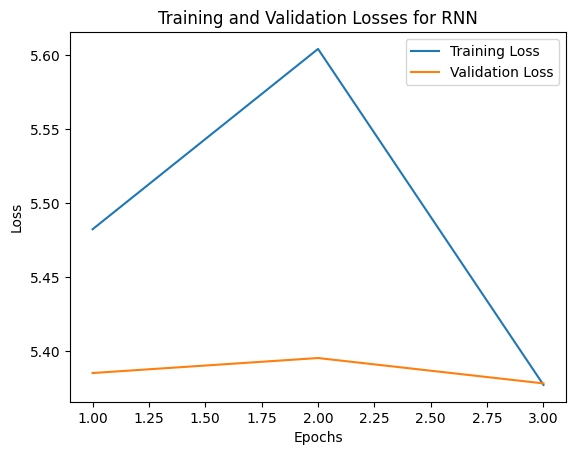

In [49]:
plot_losses('RNN', rnn_train_losses, rnn_val_losses, epochs)

# Transformer 

In [23]:
epochs = 3
embedding_dim = 512
hidden_dim = 2048
n_layers = 6
vocab_size = len(vocab)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Transformer(vocab_size, max_len - 1, embedding_dim, n_layers, hidden_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.98), eps=1e-9)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [24]:
print('Transformer Start Training:')
transformer_train_losses, transformer_val_losses, transformer_val_accs = train_and_validate(model, optimizer, criterion, train_dataloader, val_dataloader, epochs, device)

Transformer Start Training:


100%|██████████| 3000/3000 [12:15<00:00,  4.08it/s]


Epoch: 1 / 3 | Train loss: 4.087197321534156 | Val loss: 2.0016034146149955 | Val acc: 0.038688344125946364


100%|██████████| 3000/3000 [12:09<00:00,  4.11it/s]


Epoch: 2 / 3 | Train loss: 1.1987009354829787 | Val loss: 0.7651228793263435 | Val acc: 0.04857346707085768


100%|██████████| 3000/3000 [12:09<00:00,  4.11it/s]


Epoch: 3 / 3 | Train loss: 0.5216861844062806 | Val loss: 0.4162361569503943 | Val acc: 0.0513848590751489


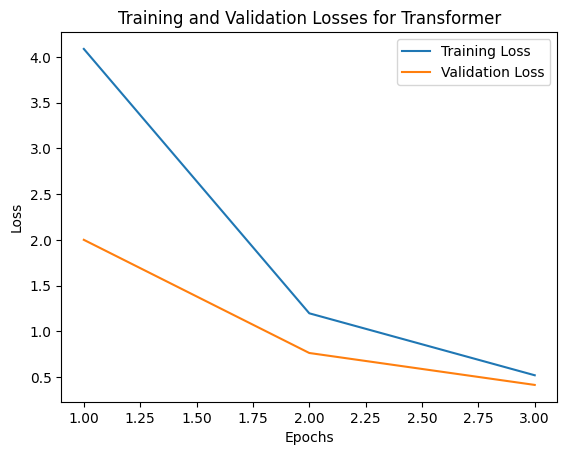

In [25]:
plot_losses('Transformer', transformer_train_losses, transformer_val_losses, epochs)

In [30]:
def generate_sequence(model_):
    model_.eval()
    with torch.no_grad():
        input_seq = torch.zeros((1,1), dtype=torch.int64).to(device)
        input_seq = input_seq.to(device)
        input_seq[:, 0] = vocab['SOS']
        padding = torch.zeros((1, max_len - 2), dtype=torch.int64).to(device)
        target_seq = torch.cat((input_seq, padding), 1)
    
        for idx in range(max_len - 2):
            prediction = model_(input_seq)
            prediction_index = prediction.argmax(dim=-1)[0][idx].item()
            predicted_word = vocab.lookup_token(prediction_index)
    
            if predicted_word != 'EOS':
                target_seq[:, idx + 1] = prediction_index
                print(predicted_word, end=' ')
    
            if predicted_word == 'EOS':
                break

In [31]:
print(generate_sequence(model))

Sorry Sorry Sorry . . . . . . . . . . . . . . the . . . . . . . . . . the the . . the . . . . . . the the the . . . . . . . . . . . . . . . . . the the the the the the . . . . . . . the the the the the the the . . . . . . . . . . . a . . . . the . the . . . 30 30 30 30 30 30 30 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 30 30 30 30 . . . . . 30 . a . . . . . 30 30 30 . . the 30 30 30 30 30 the the the 30 . 30 30 30 . . . . . . . 30 30 30 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 30 30 . 30 30 30 . . . 30 30 30 . . . . 30 . . . . . . . . . . . . . . . . . . . . . . . . . . 30 30 30 30 30 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 